# Visualize Random Validation Windows

This notebook picks 5 random windows from the validation set, plots the multi-channel signal in each window (10 ms segment), and annotates the ground truth spike count as well as the model's predicted count for that window. Make sure you have the following files accessible in the same directory (or adjust paths as needed):
- `checkpoint_epoch_{n}.pth` (your trained model checkpoint)
- (Optional) `mean.npy` and `std.npy` if you saved channel normalization stats
If not, the notebook will recompute mean/std over the training set, which may take some time.
**FHIR version used:** PyTorch, SpikeInterface, SpikeForest.

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from spikeinterface.preprocessing import bandpass_filter
import spikeforest as sf
import nbformat
import matplotlib.pyplot as plt

# For inline plotting
%matplotlib inline

In [3]:
class SpikeCountDataset(Dataset):
    def __init__(self, rec_ext, sort_ext, win_samples, mean=None, std=None):
        self.rec = rec_ext
        self.sort = sort_ext
        self.win = win_samples
        self.starts = np.arange(
            0,
            rec_ext.get_num_frames() - win_samples + 1,
            win_samples,
            dtype=np.int64
        )
        self.trains = {
            u: sort_ext.get_unit_spike_train(u, segment_index=0)
            for u in sort_ext.get_unit_ids()
        }
        self.n_chan = rec_ext.get_num_channels()

        if (mean is not None) and (std is not None):
            self.mean = torch.tensor(mean, dtype=torch.float32)
            self.std = torch.tensor(std,  dtype=torch.float32)
        else:
            self.mean = None
            self.std = None

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        s = int(self.starts[idx])
        e = s + self.win
        traces = self.rec.get_traces(start_frame=s, end_frame=e).astype(np.float32)
        traces = traces.T  # (n_chan, win_samples)
        X = torch.from_numpy(traces)

        count = sum(
            int(np.any((st >= s) & (st < e)))
            for st in self.trains.values()
        )
        y = torch.tensor(count, dtype=torch.float32)

        if (self.mean is not None) and (self.std is not None):
            mean = self.mean.unsqueeze(1)
            std  = self.std.unsqueeze(1)
            X = (X - mean) / std

        return X, y

class BasicBlock1D(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm1d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.down  = (
            nn.Sequential(
                nn.Conv1d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes),
            )
            if (stride != 1 or in_planes != planes)
            else nn.Identity()
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.down(x)
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, layers, in_ch, out_dim=1):
        super().__init__()
        self.in_planes = 64
        self.conv1     = nn.Conv1d(in_ch, 64,
                                   kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1       = nn.BatchNorm1d(64)
        self.relu      = nn.ReLU(inplace=True)
        self.maxpool   = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1    = self._make_layer(layers[0],  64)
        self.layer2    = self._make_layer(layers[1], 128, stride=2)
        self.layer3    = self._make_layer(layers[2], 256, stride=2)
        self.layer4    = self._make_layer(layers[3], 512, stride=2)
        self.avgpool   = nn.AdaptiveAvgPool1d(1)
        self.fc        = nn.Linear(512, out_dim)

    def _make_layer(self, blocks, planes, stride=1):
        layers = [BasicBlock1D(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        return self.fc(x)

In [4]:
#Load Hybrid Janelia catalog and select validation recording
uri = "sha1://43298d72b2d0860ae45fc9b0864137a976cb76e8?hybrid-janelia-spikeforest-recordings.json"
all_recordings = sf.load_spikeforest_recordings(uri)

# Validation recording name
val_name = "rec_64c_600s_12"
val_rec  = next(R for R in all_recordings if R.recording_name == val_name)
recording_val   = val_rec.get_recording_extractor()
sorting_val_gt  = val_rec.get_sorting_true_extractor()

# Training recording (for mean/std)
train_name = "rec_64c_1200s_11"
train_rec  = next(R for R in all_recordings if R.recording_name == train_name)
recording_train = train_rec.get_recording_extractor()
sorting_train_gt = train_rec.get_sorting_true_extractor()

# Filter both recordings
recording_train_f = bandpass_filter(recording_train, freq_min=300, freq_max=6000)
recording_val_f   = bandpass_filter(recording_val,   freq_min=300, freq_max=6000)

fs = recording_train_f.get_sampling_frequency()
WIN_SAMPLES = int(0.010 * fs)  # 10 ms windows (300 samples)

#Compute or load mean/std for normalization
mean_path = "mean.npy"
std_path  = "std.npy"
if os.path.exists(mean_path) and os.path.exists(std_path):
    mean = np.load(mean_path)
    std  = np.load(std_path)
    print("Loaded mean/std from disk.")
else:
    # Compute from training set (may take a while)
    train_dataset_nonnorm = SpikeCountDataset(recording_train_f, sorting_train_gt, WIN_SAMPLES)
    train_loader_nonnorm = DataLoader(train_dataset_nonnorm, batch_size=32, shuffle=True, drop_last=True, num_workers=0)

    sum_   = torch.zeros(train_dataset_nonnorm.n_chan)
    sum_sq = torch.zeros(train_dataset_nonnorm.n_chan)
    count_ = 0

    with torch.no_grad():
        for X_batch, _ in train_loader_nonnorm:
            B, C, W = X_batch.shape
            sum_   += X_batch.sum(dim=(0, 2))
            sum_sq += (X_batch ** 2).sum(dim=(0, 2))
            count_ += B * W

    mean   = (sum_ / count_).numpy()
    var    = (sum_sq / count_) - (sum_ / count_) ** 2
    std    = torch.sqrt(var).numpy()

    np.save(mean_path, mean)
    np.save(std_path, std)
    print("Computed and saved mean/std.")

Loaded mean/std from disk.


In [5]:
#Create validation dataset with normalization
val_dataset = SpikeCountDataset(recording_val_f, sorting_val_gt, WIN_SAMPLES, mean=mean, std=std)

# Load the trained model from checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet1D([2, 2, 2, 2], in_ch=val_dataset.n_chan).to(device)

# Update the path below if your checkpoint is somewhere else
checkpoint_path = "checkpoints/checkpoint_epoch_30.pth"
ckpt = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()
print(f"Loaded model from {checkpoint_path} (Epoch {ckpt['epoch']})")

Loaded model from checkpoints/checkpoint_epoch_30.pth (Epoch 30)


Selected window indices: [1952, 6140, 14328, 15247, 33118]
Saved: figures/Window_idx1952_GT_count4_Pred_count390.pdf
Saved: figures/Window_idx1952_GT_count4_Pred_count390.png


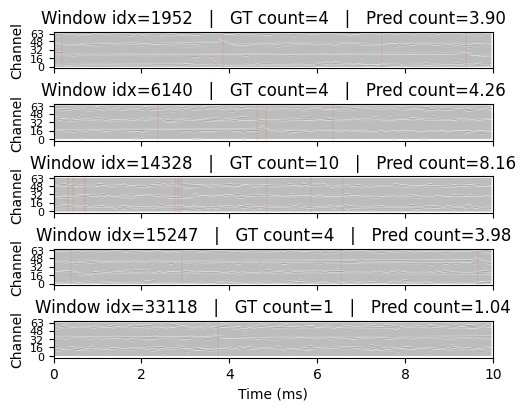

In [29]:

import numpy as np
import matplotlib.pyplot as plt

num_windows = 5  # Number of windows to visualize
total_windows = len(val_dataset)
indices = random.sample(range(total_windows), num_windows)
print(f"Selected window indices: {indices}")

fig, axes = plt.subplots(len(indices), 1, figsize=(5, 4), constrained_layout=True)

for i, idx in enumerate(indices):
    start = val_dataset.starts[idx]
    end   = start + WIN_SAMPLES

    #Fetch raw filtered traces for plotting
    raw_window = recording_val_f.get_traces(
        start_frame=int(start), end_frame=int(end)
    ).astype(np.float32).T  # shape = (64, 300)

    #Ground-truth spike times (sample indices) for all units, within [start, end)
    spike_times_ms = []
    for u in sorting_val_gt.get_unit_ids():
        st = sorting_val_gt.get_unit_spike_train(u, segment_index=0)
        # find all spikes of unit u that fall in [start, end)
        mask = (st >= start) & (st < end)
        if np.any(mask):
            # relative sample indices = st[mask] - start
            rel_samples = st[mask] - start
            # convert samples → ms
            rel_ms = rel_samples / fs * 1000
            spike_times_ms.extend(rel_ms.tolist())

    #Compute GT count and model prediction as before
    y_true = len(spike_times_ms)
    X_norm, _ = val_dataset[idx]
    with torch.no_grad():
        pred_count = model(X_norm.unsqueeze(0).to(device)).item()

    ax = axes[i]
    time_ms = np.arange(WIN_SAMPLES) / fs * 1000  # x-axis in ms

    #Plot all 64 channels (stacked vertically)
    for ch in range(raw_window.shape[0]):
        trace = raw_window[ch]
        max_val = np.max(np.abs(trace))
        if max_val > 0:
            trace_norm = trace / max_val * 0.4
        else:
            trace_norm = trace * 0.0
        offset = ch
        ax.plot(time_ms, trace_norm + offset, color='black', linewidth=0.1)

    #Overlay vertical ticks at each GT spike time across the entire y-range
    for t in spike_times_ms:
        ax.axvline(
            x=t,
            color='red',
            linestyle=':',
            linewidth=0.3,
            alpha=0.6
        )

    ax.set_title(
        f"Window idx={idx}   |   GT count={y_true}   |   Pred count={pred_count:.2f}",
        fontsize=10
    )
    ax.set_xlim([0, WIN_SAMPLES / fs * 1000])
    ax.set_ylabel("Channel")
    ax.set_yticks([0, 16, 32, 48, 63])
    ax.set_yticklabels([0, 16, 32, 48, 63], fontsize=8)
    if i == len(indices) - 1:
        ax.set_xlabel("Time (ms)")
    else:
        ax.set_xticklabels([])
save_fig()
plt.show()


In [18]:
import matplotlib.pyplot as plt
import re
import os

os.makedirs('figures', exist_ok=True)
def save_fig(fig=None, dpi=1000, formats=('pdf', 'png')):
    if fig is None:
        fig = plt.gcf()
    
    # Get axes and find title
    axes = fig.get_axes()
    if not axes:
        title = None
    else:
        # Try to get title from main axes
        title = axes[0].get_title()
        
        # If no title in first axes, check others
        if not title and len(axes) > 1:
            for ax in axes:
                if ax.get_title():
                    title = ax.get_title()
                    break
    
    # Create filename from title
    if title:
        # Sanitize title for filename
        filename = re.sub(r'[^\w\s-]', '', title)
        filename = re.sub(r'[\s-]+', '_', filename).strip('_')
        filename = filename[:100]  # Limit length
    else:
        # Default name if no title
        import time
        filename = f"figure_{int(time.time())}"
    
    # Store titles and then remove them
    titles = {}
    for ax in axes:
        if ax.get_title():
            titles[ax] = ax.get_title()
            ax.set_title("")
    
    # Save figure without titles
    for fmt in formats:
        filepath = f'figures/{filename}.{fmt}'
        fig.savefig(filepath, dpi=dpi if fmt != 'pdf' else None, bbox_inches='tight')
        print(f"Saved: {filepath}")
    
    # Restore titles
    for ax, title in titles.items():
        ax.set_title(title)
    
    return fig  # Return figure for chaining

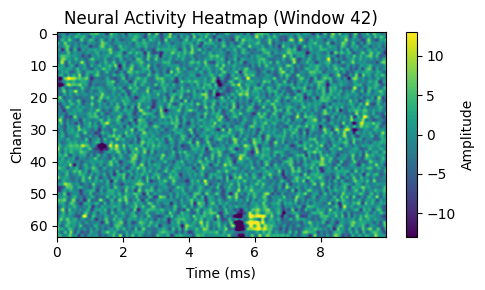

In [33]:
# Heatmap visualization of a window's activity across channels and time
def plot_neural_heatmap(window_idx, val_dataset, recording_val_f, sorting_val_gt, fs, WIN_SAMPLES):
    start = val_dataset.starts[window_idx]
    end = start + WIN_SAMPLES
    
    # Get raw filtered traces
    raw_window = recording_val_f.get_traces(
        start_frame=int(start), end_frame=int(end)
    ).astype(np.float32)  # shape = (300, 64)
    
    # Get spike times for annotation
    spike_times_samples = []
    spike_channels = []
    
    for u in sorting_val_gt.get_unit_ids():
        st = sorting_val_gt.get_unit_spike_train(u, segment_index=0)
        # Find spikes in this window
        mask = (st >= start) & (st < end)
        if np.any(mask):
            # Get relative sample indices
            rel_samples = st[mask] - start
            spike_times_samples.extend(rel_samples.tolist())
            
            # Get channel with maximum amplitude for this unit
            spike_channels.extend([u % 64] * np.sum(mask)) 
    
    # Create heatmap
    time_ms = np.arange(WIN_SAMPLES) / fs * 1000
    
    plt.figure(figsize=(5, 3))
    
    # Normalize for better visualization
    vmax = np.percentile(np.abs(raw_window), 99.5)
    plt.imshow(raw_window.T, aspect='auto', cmap='viridis', 
               extent=[0, time_ms[-1], 63.5, -0.5],  # Note: channels go from top to bottom
               vmin=-vmax, vmax=vmax)
    
    # Mark spike times
    # for t, c in zip(spike_times_samples, spike_channels):
    #     t_ms = t / fs * 1000
    #     plt.scatter(t_ms, c, color='red', s=30, marker='*', edgecolors='white')
        
    for t in spike_times_samples:
        ax.axvline(
            x=t,
            color='red',
            linestyle=':',
            linewidth=0.5,
            alpha=0.6
        )
    
    plt.colorbar(label='Amplitude')
    plt.title(f'Neural Activity Heatmap (Window {window_idx})')
    plt.xlabel('Time (ms)')
    plt.ylabel('Channel')
    plt.tight_layout()
    # save_fig()
    plt.show()

window_idx = 42  #random window
plot_neural_heatmap(window_idx, val_dataset, recording_val_f, sorting_val_gt, fs, WIN_SAMPLES)

Saved: figures/Neural_Activity_Heatmap_Window_42_5_spikes.pdf
Saved: figures/Neural_Activity_Heatmap_Window_42_5_spikes.png


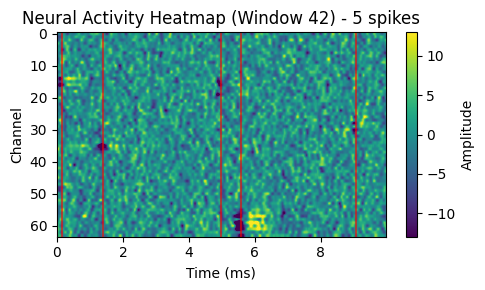

In [42]:
# Heatmap visualization of a window's activity across channels and time
def plot_neural_heatmap(window_idx, val_dataset, recording_val_f, sorting_val_gt, fs, WIN_SAMPLES):
    start = val_dataset.starts[window_idx]
    end = start + WIN_SAMPLES
    
    # Get raw filtered traces
    raw_window = recording_val_f.get_traces(
        start_frame=int(start), end_frame=int(end)
    ).astype(np.float32)  # shape = (300, 64)
    
    # Get spike times for annotation
    spike_times_samples = []
    spike_channels = []
    spike_unit_ids = []  # Keep track of which unit each spike belongs to
    
    for u in sorting_val_gt.get_unit_ids():
        st = sorting_val_gt.get_unit_spike_train(u, segment_index=0)
        # Find spikes in this window
        mask = (st >= start) & (st < end)
        if np.any(mask):
            # Get relative sample indices
            rel_samples = st[mask] - start
            spike_times_samples.extend(rel_samples.tolist())
            
            # For display purposes, assign each unit to a channel
            # This is just a placeholder - in reality, you'd want to determine the
            # actual channel with max amplitude for each unit
            spike_channels.extend([u % 64] * np.sum(mask))
            spike_unit_ids.extend([u] * np.sum(mask))
    
    # Create heatmap
    time_ms = np.arange(WIN_SAMPLES) / fs * 1000
    
    fig, ax = plt.subplots(figsize=(5, 3))
    
    # Normalize for better visualization
    vmax = np.percentile(np.abs(raw_window), 99.5)
    im = ax.imshow(raw_window.T, aspect='auto', cmap='viridis', 
               extent=[0, time_ms[-1], 63.5, -0.5],  # Note: channels go from top to bottom
               vmin=-vmax, vmax=vmax)
    
    # Convert spike times from samples to milliseconds for plotting
    spike_times_ms = [t / fs * 1000 for t in spike_times_samples]
    
    for t_ms in spike_times_ms:
        ax.axvline(
            x=t_ms,
            color='red',
            linewidth=1.5,
            alpha=0.6
        )
    # Add count of spikes in title
    ax.set_title(f'Neural Activity Heatmap (Window {window_idx}) - {len(spike_times_ms)} spikes')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Amplitude')
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Channel')
    
    plt.tight_layout()
    save_fig()
    plt.show()


window_idx = 42  # random window
plot_neural_heatmap(window_idx, val_dataset, recording_val_f, sorting_val_gt, fs, WIN_SAMPLES)

Saved: figures/t_00_ms.pdf
Saved: figures/t_00_ms.png


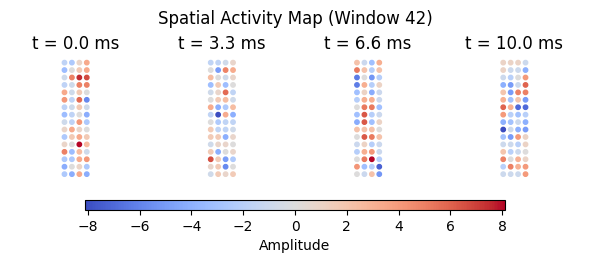

In [26]:
def plot_spatial_activity(window_idx, val_dataset, recording_val_f, sorting_val_gt, fs, WIN_SAMPLES):
    start = val_dataset.starts[window_idx]
    end = start + WIN_SAMPLES
    
    # Get raw filtered traces
    raw_window = recording_val_f.get_traces(
        start_frame=int(start), end_frame=int(end)
    ).astype(np.float32)  # shape = (300, 64)
    
    # For Neuropixels, often 4 columns with evenly spaced rows
    n_channels = recording_val_f.get_num_channels()
    cols = 4
    rows = n_channels // cols
    x_pos = np.repeat(np.arange(cols), rows)[:n_channels]
    y_pos = np.tile(np.arange(rows), cols)[:n_channels]
    
    # Compute RMS value for each channel in this window
    rms = np.sqrt(np.mean(raw_window**2, axis=0))
    
    # Create snapshots at different time points
    n_snapshots = 4
    snapshot_indices = np.linspace(0, WIN_SAMPLES-1, n_snapshots, dtype=int)
    
    plt.figure(figsize=(6, 2))
    for i, idx in enumerate(snapshot_indices):
        plt.subplot(1, n_snapshots, i+1)
        
        # Get amplitude at this time point
        amplitudes = raw_window[idx, :]
        
        # Normalize for visualization
        vmax = np.percentile(np.abs(amplitudes), 99)
        
        # Scatter plot with color representing amplitude
        scatter = plt.scatter(x_pos, y_pos, c=amplitudes, cmap='coolwarm', 
                             s=10, vmin=-vmax, vmax=vmax)
        
        plt.title(f't = {idx/fs*1000:.1f} ms')
        plt.xlim(-0.5, cols-0.5)
        plt.ylim(-0.5, rows-0.5)
        plt.axis('equal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    # Add colorbar
    cbar_ax = plt.axes([0.15, 0.05, 0.7, 0.05])
    plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='Amplitude')
    
    plt.suptitle(f'Spatial Activity Map (Window {window_idx})', y=1.05)
    save_fig()
    plt.show()

plot_spatial_activity(42, val_dataset, recording_val_f, sorting_val_gt, fs, WIN_SAMPLES)

Saved: figures/Time_Domain_Signal.pdf
Saved: figures/Time_Domain_Signal.png


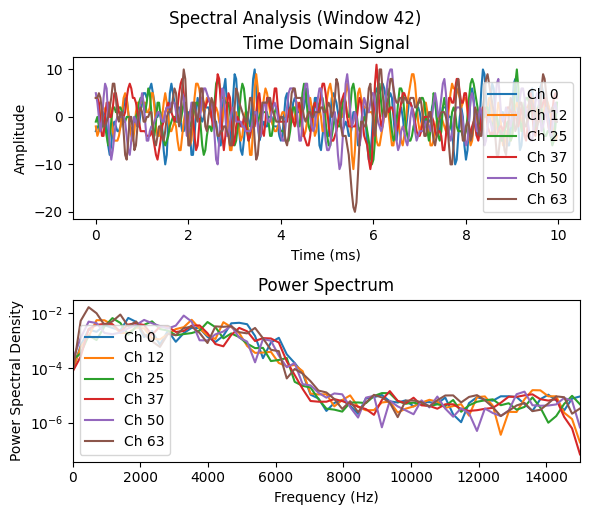

In [21]:
def plot_spectral_analysis(window_idx, val_dataset, recording_val_f, fs, WIN_SAMPLES):
    start = val_dataset.starts[window_idx]
    end = start + WIN_SAMPLES
    
    # Get raw filtered traces
    raw_window = recording_val_f.get_traces(
        start_frame=int(start), end_frame=int(end)
    ).astype(np.float32)  # shape = (300, 64)
    
    # Compute power spectrum for each channel
    from scipy import signal
    
    # Select a subset of channels to display
    channels_to_show = np.linspace(0, 63, 6, dtype=int)
    
    plt.figure(figsize=(6, 5))
    
    # Plot time domain signal for selected channels
    plt.subplot(2, 1, 1)
    time_ms = np.arange(WIN_SAMPLES) / fs * 1000
    
    for ch in channels_to_show:
        plt.plot(time_ms, raw_window[:, ch], label=f'Ch {ch}')
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.title('Time Domain Signal')
    plt.legend()
    
    # Plot power spectrum
    plt.subplot(2, 1, 2)
    for ch in channels_to_show:
        f, Pxx = signal.welch(raw_window[:, ch], fs=fs, nperseg=128)
        plt.semilogy(f, Pxx, label=f'Ch {ch}')
    
    plt.xlim(0, fs/2)  # Nyquist frequency
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Power Spectrum')
    plt.legend()
    
    plt.tight_layout()
    plt.suptitle(f'Spectral Analysis (Window {window_idx})', y=1.02)
    save_fig()
    plt.show()
plot_spectral_analysis(42, val_dataset, recording_val_f, fs, WIN_SAMPLES)

/var/folders/9t/2kmyzb_x00j95kxczknqc02c0000gn/T/ipykernel_98512/2684844376.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


Saved: figures/Unit_1_Ch_20.pdf
Saved: figures/Unit_1_Ch_20.png


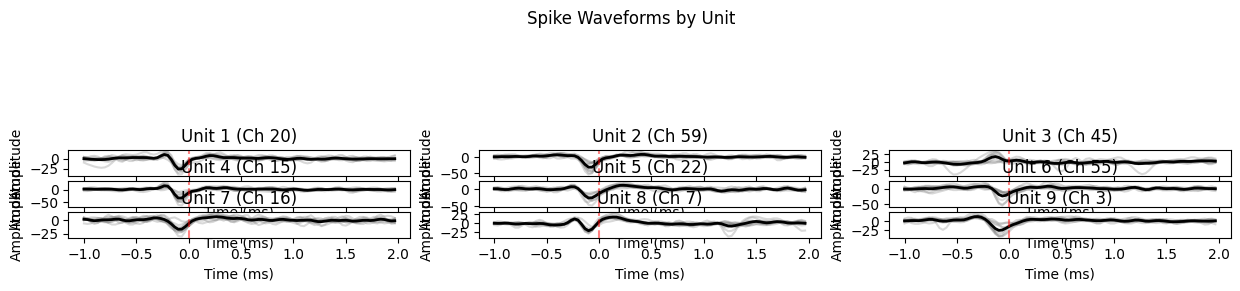

In [22]:
def plot_spike_waveforms(sorting_val_gt, recording_val_f, num_waveforms=10):
    # Get all units
    unit_ids = sorting_val_gt.get_unit_ids()
    
    # Extract waveforms for each unit
    waveform_length = int(0.003 * fs)  # 3 ms window
    pre_samples = int(0.001 * fs)      # 1 ms before spike peak
    
    plt.figure(figsize=(15, 10))
    rows = int(np.ceil(len(unit_ids) / 3))
    cols = min(3, len(unit_ids))
    
    for i, unit_id in enumerate(unit_ids[:9]):  # Show first 9 units
        # Get spike times for this unit
        spike_times = sorting_val_gt.get_unit_spike_train(unit_id, segment_index=0)
        
        # Select random spikes (up to num_waveforms)
        if len(spike_times) > num_waveforms:
            selected_spikes = np.random.choice(spike_times, num_waveforms, replace=False)
        else:
            selected_spikes = spike_times
        
        # Extract waveforms
        waveforms = []
        for t in selected_spikes:
            if t >= pre_samples and t < recording_val_f.get_num_frames() - (waveform_length - pre_samples):
                start_frame = t - pre_samples
                end_frame = t + (waveform_length - pre_samples)
                waveform = recording_val_f.get_traces(start_frame=int(start_frame), 
                                                      end_frame=int(end_frame))
                waveforms.append(waveform)
        
        if not waveforms:
            continue
            
        waveforms = np.stack(waveforms, axis=0)  # (n_spikes, n_samples, n_channels)
        
        # Find the channel with maximum amplitude for this unit
        avg_waveform = np.mean(waveforms, axis=0)
        peak_channel = np.argmax(np.max(np.abs(avg_waveform), axis=0))
        
        # Plot individual waveforms and average
        plt.subplot(rows, cols, i+1)
        time_ms = np.arange(waveform_length) / fs * 1000 - (pre_samples / fs * 1000)
        
        for j in range(min(len(waveforms), 10)):
            plt.plot(time_ms, waveforms[j, :, peak_channel], 'gray', alpha=0.3)
            
        plt.plot(time_ms, np.mean(waveforms, axis=0)[:, peak_channel], 'k', linewidth=2)
        
        plt.axvline(x=0, linestyle='--', color='r', alpha=0.5)
        plt.title(f'Unit {unit_id} (Ch {peak_channel})')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.suptitle('Spike Waveforms by Unit', y=1.02)
    save_fig()
    plt.show()
plot_spike_waveforms(sorting_val_gt, recording_val_f)

Saved: figures/Spike_Raster_Plot_Around_Window_42.pdf
Saved: figures/Spike_Raster_Plot_Around_Window_42.png


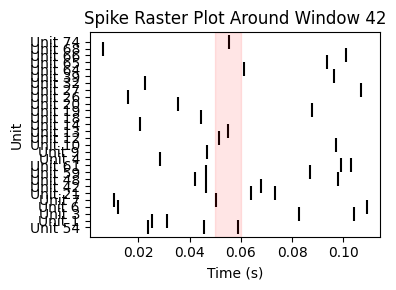

In [23]:
def plot_spike_raster(window_idx, val_dataset, sorting_val_gt, fs, WIN_SAMPLES, extra_time=0.05):
    start = val_dataset.starts[window_idx]
    # Look at a slightly larger window for context
    start_extended = max(0, start - int(extra_time * fs))
    end_extended = min(start + WIN_SAMPLES + int(extra_time * fs), 10000000)
    
    # Get all units
    unit_ids = sorting_val_gt.get_unit_ids()
    
    # Collect spike times for each unit
    spikes_by_unit = []
    for unit_id in unit_ids:
        st = sorting_val_gt.get_unit_spike_train(unit_id, segment_index=0)
        # Find spikes in extended window
        mask = (st >= start_extended) & (st < end_extended)
        if np.any(mask):
            rel_times = (st[mask] - start_extended) / fs  # Convert to seconds
            spikes_by_unit.append((unit_id, rel_times))
    
    # Sort by firing rate
    spikes_by_unit.sort(key=lambda x: len(x[1]), reverse=True)
    
    # Create raster plot
    plt.figure(figsize=(4, 3))
    
    for i, (unit_id, spike_times) in enumerate(spikes_by_unit):
        plt.scatter(spike_times, np.ones_like(spike_times) * i, marker='|', 
                   s=100, color='black')
    
    # Mark the window of interest
    window_start = (start - start_extended) / fs
    window_end = window_start + WIN_SAMPLES / fs
    plt.axvspan(window_start, window_end, color='red', alpha=0.1)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Unit')
    plt.yticks(range(len(spikes_by_unit)), 
              [f'Unit {unit_id}' for unit_id, _ in spikes_by_unit])
    plt.title(f'Spike Raster Plot Around Window {window_idx}')
    plt.tight_layout()
    save_fig()
    plt.show()

plot_spike_raster(42, val_dataset, sorting_val_gt, fs, WIN_SAMPLES)

Total units: 74
Units with spikes in this window: 28


UnboundLocalError: local variable 'tick_interval' referenced before assignment

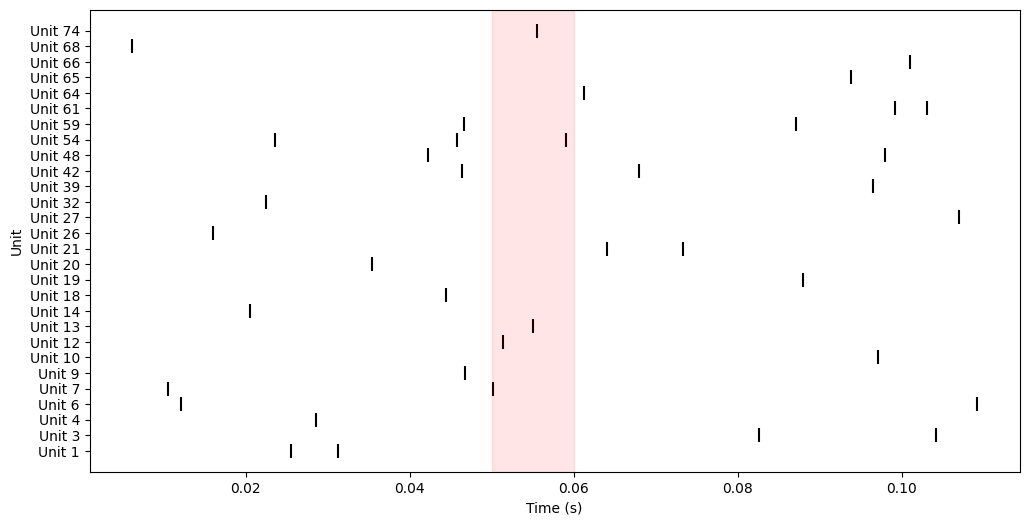

In [24]:
def plot_spike_raster(window_idx, val_dataset, sorting_val_gt, fs, WIN_SAMPLES, extra_time=0.05):
    start = val_dataset.starts[window_idx]
    # Look at a slightly larger window for context
    start_extended = max(0, start - int(extra_time * fs))
    end_extended = min(start + WIN_SAMPLES + int(extra_time * fs), 10000000)
    
    # Get all units
    unit_ids = sorting_val_gt.get_unit_ids()
    print(f"Total units: {len(unit_ids)}")
    
    # Collect spike times for each unit
    spikes_by_unit = []
    for unit_id in unit_ids:
        st = sorting_val_gt.get_unit_spike_train(unit_id, segment_index=0)
        # Find spikes in extended window
        mask = (st >= start_extended) & (st < end_extended)
        if np.any(mask):
            rel_times = (st[mask] - start_extended) / fs  # Convert to seconds
            spikes_by_unit.append((unit_id, rel_times))
    
    # Sort by unit ID for consistent visualization
    spikes_by_unit.sort(key=lambda x: x[0])
    
    print(f"Units with spikes in this window: {len(spikes_by_unit)}")
    
    # Create raster plot with proper sizing
    height_per_unit = 0.2  # inches per unit
    min_height = 6  # minimum figure height
    fig_height = max(min_height, len(spikes_by_unit) * height_per_unit)
    
    plt.figure(figsize=(12, fig_height))
    
    # Create raster
    for i, (unit_id, spike_times) in enumerate(spikes_by_unit):
        plt.scatter(spike_times, np.ones_like(spike_times) * i, marker='|', 
                   s=100, color='black')
    
    # Mark the window of interest
    window_start = (start - start_extended) / fs
    window_end = window_start + WIN_SAMPLES / fs
    plt.axvspan(window_start, window_end, color='red', alpha=0.1)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Unit')
    
    # Optimize y-ticks for readability
    if len(spikes_by_unit) <= 30:
        # Show all units if there aren't too many
        plt.yticks(range(len(spikes_by_unit)), 
                  [f'Unit {unit_id}' for unit_id, _ in spikes_by_unit])
    else:
        # For many units, show ticks at intervals
        tick_interval = max(1, len(spikes_by_unit) // 20)  # Show ~20 ticks
        tick_positions = range(0, len(spikes_by_unit), tick_interval)
        tick_labels = [f'Unit {spikes_by_unit[i][0]}' for i in tick_positions]
        plt.yticks(tick_positions, tick_labels)
    
    # Add spike count information
    for i, (unit_id, spike_times) in enumerate(spikes_by_unit):
        if i % tick_interval == 0 or len(spikes_by_unit) <= 30:  # Only annotate at tick positions if many units
            plt.text(window_end + extra_time*0.2, i, f"({len(spike_times)} spikes)", 
                    fontsize=8, va='center')
    
    # Add horizontal lines to help track across
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add vertical line at window boundaries
    plt.axvline(x=window_start, color='red', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=window_end, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # Set limits
    plt.xlim(0, (end_extended - start_extended) / fs)
    plt.ylim(-0.5, len(spikes_by_unit) - 0.5)
    
    # Add title with stats
    total_spikes = sum(len(spikes) for _, spikes in spikes_by_unit)
    plt.title(f'Spike Raster Plot (Window {window_idx}) - {len(spikes_by_unit)} active units, {total_spikes} spikes')
    
    plt.tight_layout()
    save_fig()
    plt.show()
    
    # Return summary for convenience
    return {
        'window_idx': window_idx,
        'active_units': len(spikes_by_unit),
        'total_spikes': total_spikes,
        'units': [u[0] for u in spikes_by_unit]
    }

plot_spike_raster(42, val_dataset, sorting_val_gt, fs, WIN_SAMPLES)

Saved: figures/Unit_14_Unit_18.pdf
Saved: figures/Unit_14_Unit_18.png


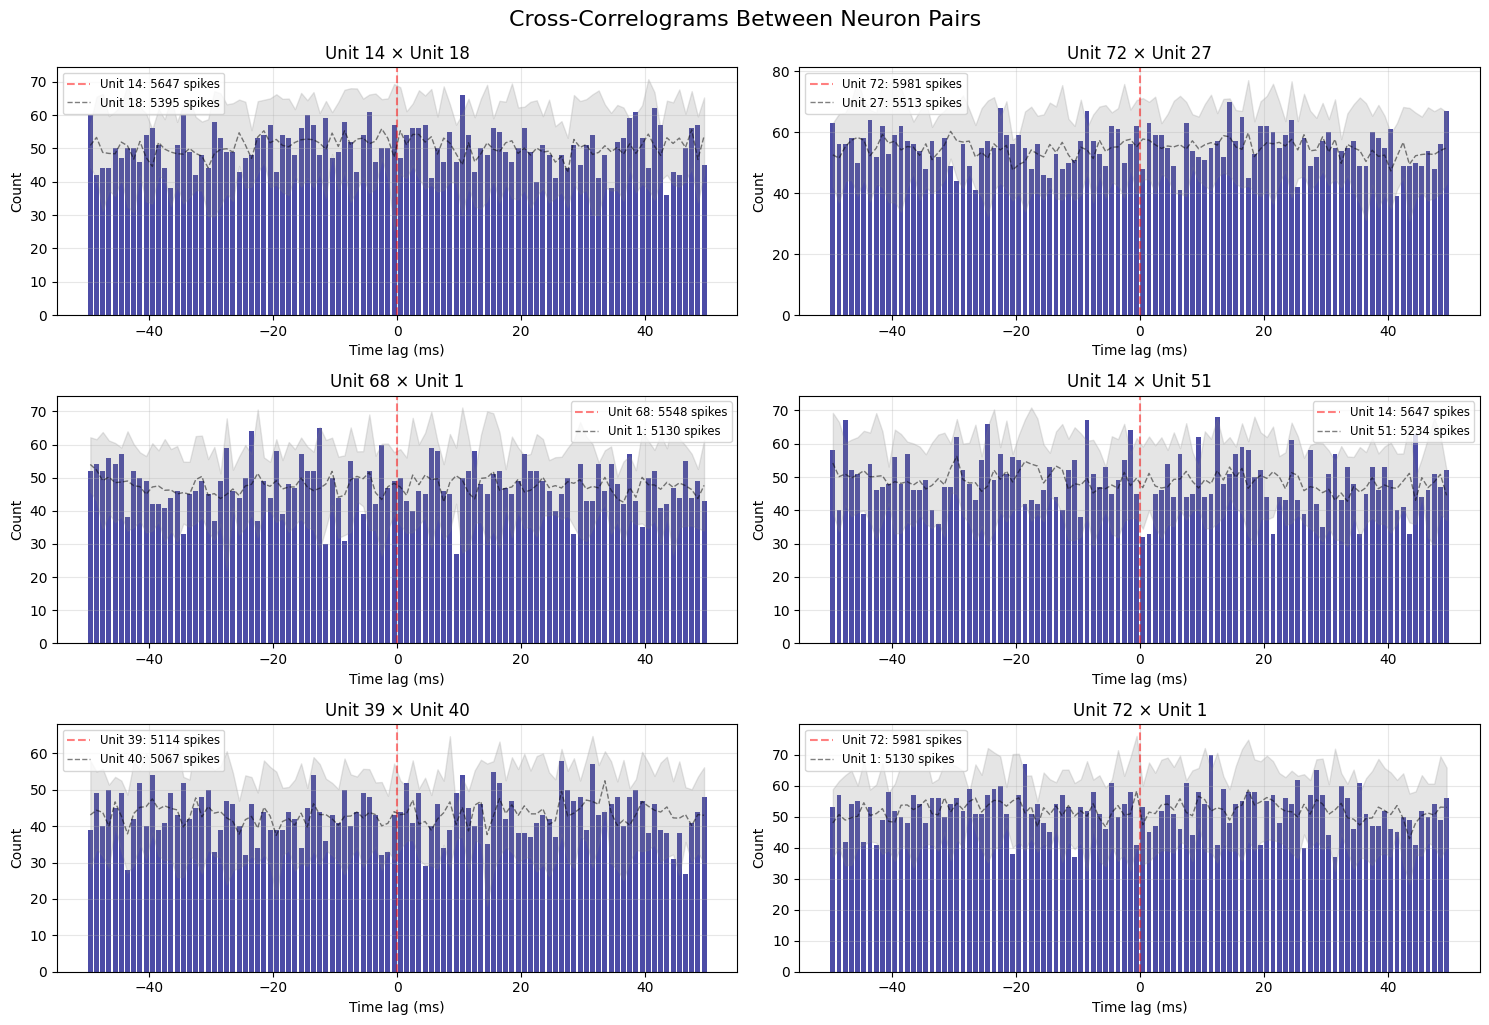

In [25]:
def plot_cross_correlograms(sorting_val_gt, fs, max_pairs=6, window_ms=50, bin_ms=1):
    # Get all units
    unit_ids = sorting_val_gt.get_unit_ids()
    
    # Count spikes for each unit and select only units with enough spikes
    min_spikes = 50
    active_units = []
    for unit_id in unit_ids:
        st = sorting_val_gt.get_unit_spike_train(unit_id, segment_index=0)
        if len(st) >= min_spikes:
            active_units.append((unit_id, len(st)))
    
    # Sort by spike count (descending)
    active_units.sort(key=lambda x: x[1], reverse=True)
    active_unit_ids = [u[0] for u in active_units[:12]]  # Take top 12 most active units
    
    # Create pairs of units
    import itertools
    pairs = list(itertools.combinations(active_unit_ids, 2))
    
    # Randomly select pairs if there are too many
    if len(pairs) > max_pairs:
        import random
        random.seed(42)  # For reproducibility
        pairs = random.sample(pairs, max_pairs)
    
    # Compute cross-correlograms
    bin_size = int(bin_ms * fs / 1000)  # bin size in samples
    window_size = int(window_ms * fs / 1000)  # window size in samples
    bins = np.arange(-window_size, window_size + bin_size, bin_size)
    # bin_centers_ms = 1000 * bin_centers / fs  # Convert to ms
    
    plt.figure(figsize=(15, 10))
    rows = int(np.ceil(len(pairs) / 2))
    cols = 2
    
    for i, (unit1, unit2) in enumerate(pairs):
        # Get spike trains
        st1 = sorting_val_gt.get_unit_spike_train(unit1, segment_index=0)
        st2 = sorting_val_gt.get_unit_spike_train(unit2, segment_index=0)
        
        # Compute cross-correlogram
        cross_corr = np.zeros(len(bins) - 1)
        
        # For each spike of unit1, find time differences to all spikes of unit2
        all_diffs = []
        for t1 in st1:
            diffs = st2 - t1
            # Only include differences within our window
            mask = (diffs >= -window_size) & (diffs <= window_size)
            all_diffs.extend(diffs[mask])
        
        # Create histogram of time differences
        if all_diffs:
            hist, _ = np.histogram(all_diffs, bins=bins)
            cross_corr = hist
        
        # Plot
        plt.subplot(rows, cols, i + 1)
        
        # Calculate bin centers in ms
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_centers_ms = bin_centers / fs * 1000
        
        plt.bar(bin_centers_ms, cross_corr, width=bin_ms*0.8, color='navy', alpha=0.7)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        
        n_shuffles = 10
        shuffle_hist = np.zeros((n_shuffles, len(bins) - 1))
        
        for s in range(n_shuffles):
            # Jitter spikes by a random amount within ±10 ms
            jitter_samples = int(10 * fs / 1000)
            st2_shuffled = st2 + np.random.randint(-jitter_samples, jitter_samples, len(st2))
            
            all_diffs_shuffled = []
            for t1 in st1:
                diffs = st2_shuffled - t1
                mask = (diffs >= -window_size) & (diffs <= window_size)
                all_diffs_shuffled.extend(diffs[mask])
            
            if all_diffs_shuffled:
                hist_shuffled, _ = np.histogram(all_diffs_shuffled, bins=bins)
                shuffle_hist[s] = hist_shuffled
        
        # Plot confidence bounds from shuffled data
        if n_shuffles > 0:
            shuffle_mean = np.mean(shuffle_hist, axis=0)
            shuffle_std = np.std(shuffle_hist, axis=0)
            plt.plot(bin_centers_ms, shuffle_mean, 'k--', alpha=0.5, linewidth=1)
            plt.fill_between(bin_centers_ms, 
                            shuffle_mean - 2*shuffle_std, 
                            shuffle_mean + 2*shuffle_std, 
                            color='gray', alpha=0.2)
        
        # Formatting
        plt.title(f'Unit {unit1} × Unit {unit2}')
        plt.xlabel('Time lag (ms)')
        plt.ylabel('Count')
        plt.grid(alpha=0.3)
        
        # Add spike counts in legend
        plt.legend([f'Unit {unit1}: {len(st1)} spikes', 
                   f'Unit {unit2}: {len(st2)} spikes'], 
                  fontsize='small')
    
    plt.tight_layout()
    plt.suptitle('Cross-Correlograms Between Neuron Pairs', y=1.02, fontsize=16)
    save_fig()
    plt.show()

plot_cross_correlograms(sorting_val_gt, fs, max_pairs=6, window_ms=50, bin_ms=1)